# Constructing GeMS dataset

> Before following this tutorial, please note that the GeMS dataset can be downloaded from the [GeMS HuggingFace repository](https://huggingface.co/datasets/roman-bushuiev/GeMS). This tutorial is designed to make the dataset construction reproducible. It is particularly important for the future expansion of the dataset or for the construction of similar datasets based on other repositories beyond GNPS.

This tutorial explains the construction of the GeMS dataset from scratch. The procedure consists of the following four steps.

1. **Determine GNPS files to download**: Identify and gather the filenames that need to be downloaded.
2. **Download and process files**: Download `.mzML` and `.mzXML` files and convert them to `.hdf5` format.
3. **Merge and filter files to GeMS-X**: Combine the `.hdf5` files and filter them according to A, B, or C format (X in the name).
4. **Subset GeMS-X with LSH to get GeMS-XY**: Use Locality-Sensitive Hashing (LSH) to cluster spectra and sample up to Y spectra per cluster.

Please note that the construction procedure demands approximately 3 TB of disk space and several weeks of running time, even when parallelized across multiple CPUs. The primary bottleneck is downloading individual files from MassIVE GNPS, which cannot be effectively parallelized without overloading the server. Therefore, this tutorial demonstrates the procedure using only five files (instead of hundreds of thousands). However, we show that each step requires a single call to a Python function, which can be straightforwardly parallelized on a computational cluster (we also provide the corresponding command line wrappers in `dreams/cli.py`).

Please also note that the described workflow is not identical to the one used to construct the original dataset. We have recently upgraded it with GNPS2 utilities and significantly simplified our codebase. This update may affect the reproducibility.

In [1]:
# Importing the necessary libraries
import dreams.utils.io as io
from pathlib import Path

Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## 1. Determine GNPS Files to Download

Our HuggingFace repository contains a [list of files](https://huggingface.co/datasets/roman-bushuiev/GeMS/blob/main/data/auxiliary/gnps_mris.tsv) that were originally collected to construct GeMS in November 2022. Nevertheless, since the data size on MassIVE GNPS has substantially increased over the years, we recommend to include new files when reconstructing the dataset from scratch.

Using GNPS2, all files currently available for download can be accessed at [this link](https://datasetcache.gnps2.org/datasette/database/uniquemri) and then filtered to include only `.mzML` and `.mzXML` files. 

In [2]:
gems_dir = Path('../data/GeMS/')
mris_pth = gems_dir / 'auxiliary/gnps_mris_test.tsv'
!head $mris_pth

cusi
mzspec:MSV000086206:ccms_peak/raw/S_N3.mzML
mzspec:MSV000086550:ccms_peak/mzXML/DATA_PLATE_10_mzXML/PLT10_A5_GA5_01_58515.mzML
mzspec:MSV000084145:ccms_peak/2017-Harvest/Run2-3-4/36217kelem8.mzML
mzspec:MSV000078616:spectrum/Rotten_Apple/P1-B-9_P1-B-9_01_3662.mzXML
mzspec:MSV000081582:ccms_peak/Skin%20samples/24C1_RC1_01_15193.mzML


The prepared file contains a column of MRIs, which are file-level equivalents of the Universal Spectrum Identifier. Each MRI represents a single file of interest.

## 2. Download and Process Files

For downloading the files, we will use the [`downloadpublicdata` Python package](https://github.com/Wang-Bioinformatics-Lab/downloadpublicdata) developed by the Wang Bioinformatics Lab. Given a list of MRIs in `mris_pth`, the `download_public_data_usi` utility will download all the files to the `out_dir` folder and store the status of each file in `log_file_pth`.

In [3]:
# Download public data using the download_public_data_usi.py script
out_dir = gems_dir / 'downloads'
log_file_pth = out_dir / 'summary.tsv'

# Create the output directory if it does not exist
out_dir.mkdir(parents=True, exist_ok=True)

# Run the download_public_data_usi.py script with the specified arguments
!python ../../downloadpublicdata/bin/download_public_data_usi.py $mris_pth $out_dir $log_file_pth

cDownloading mzspec:MSV000086206:ccms_peak/raw/S_N3.mzML
mzspec:MSV000086206:ccms_peak/raw/S_N3.mzML downloaded successfully to target location at ../data/GeMS/downloads/S_N3.mzML
mzspec:MSV000086550:ccms_peak/mzXML/DATA_PLATE_10_mzXML/PLT10_A5_GA5_01_58515.mzML downloaded successfully to target location at ../data/GeMS/downloads/PLT10_A5_GA5_01_58515.mzML
mzspec:MSV000084145:ccms_peak/2017-Harvest/Run2-3-4/36217kelem8.mzML downloaded successfully to target location at ../data/GeMS/downloads/36217kelem8.mzML
mzspec:MSV000078616:spectrum/Rotten_Apple/P1-B-9_P1-B-9_01_3662.mzXML downloaded successfully to target location at ../data/GeMS/downloads/P1-B-9_P1-B-9_01_3662.mzXML
mzspec:MSV000081582:ccms_peak/Skin%20samples/24C1_RC1_01_15193.mzML downloaded successfully to target location at ../data/GeMS/downloads/24C1_RC1_01_15193.mzML


Next, we will convert each downloaded `.mzML` and `.mzXML` file into our `.hdf5`-based format. The details about this format are described in a separate tutorial titled "Working with MS/MS Data Using HDF5". This step also removes corrupted or empty files and collects data statistics which are helpful for the next steps.

In [4]:
io.downloadpublicdata_to_hdf5s(log_file_pth)

2024-08-01 00:06:28,618 | INFO | Started processing ../data/GeMS/downloads/S_N3.mzML
2024-08-01 00:06:32,187 | INFO | Num. of MS1 spectra: 2740
2024-08-01 00:06:32,187 | INFO | Collected 4052 from 4052 total num. of MSn spectra
2024-08-01 00:06:32,194 | INFO | Spectra problems: {}
2024-08-01 00:06:32,195 | INFO | Precursor spectra problems: {}
2024-08-01 00:06:32,517 | INFO | Started processing ../data/GeMS/downloads/PLT10_A5_GA5_01_58515.mzML


/Users/builder/jenkins/ws/enms_ntly_pyoms_whl_Release3.0.0/OpenMS/src/openms/source/FORMAT/HANDLERS/XMLHandler.cpp(130): While loading '../data/GeMS/downloads/PLT10_A5_GA5_01_58515.mzML': Required attribute 'softwareRef' not present!
The software tool which generated this mzML should be fixed. Please notify the maintainers.


Expecting a single source file in mzML. Found 2 will take only first one for rewriting.
2024-08-01 00:06:35,198 | INFO | Num. of MS1 spectra: 371
2024-08-01 00:06:35,199 | INFO | Collected 1747 from 1851 total num. of MSn spectra
2024-08-01 00:06:35,202 | INFO | Spectra problems: {"No peaks": 104}
2024-08-01 00:06:35,202 | INFO | Precursor spectra problems: {}
2024-08-01 00:06:35,832 | INFO | Started processing ../data/GeMS/downloads/36217kelem8.mzML
Expecting a single source file in mzML. Found 9 will take only first one for rewriting.
2024-08-01 00:06:36,285 | INFO | Not processing the file because of MSLevelsOrder.UNIFORM_MS1
2024-08-01 00:06:36,497 | INFO | Started processing ../data/GeMS/downloads/P1-B-9_P1-B-9_01_3662.mzXML
2024-08-01 00:06:36,623 | INFO | Num. of MS1 spectra: 237
2024-08-01 00:06:36,624 | INFO | Collected 986 from 1380 total num. of MSn spectra
2024-08-01 00:06:36,627 | INFO | Spectra problems: {"No peaks": 394}
2024-08-01 00:06:36,627 | INFO | Precursor spectra

/Users/builder/jenkins/ws/enms_ntly_pyoms_whl_Release3.0.0/OpenMS/src/openms/source/FORMAT/HANDLERS/XMLHandler.cpp(130): While loading '../data/GeMS/downloads/24C1_RC1_01_15193.mzML': Required attribute 'softwareRef' not present!


2024-08-01 00:06:47,603 | INFO | Num. of MS1 spectra: 983
2024-08-01 00:06:47,605 | INFO | Collected 3913 from 3913 total num. of MSn spectra
2024-08-01 00:06:47,610 | INFO | Spectra problems: {}
2024-08-01 00:06:47,610 | INFO | Precursor spectra problems: {}


## 3. Merge and filter files to GeMS-X

Everything is now prepared to form the initial GeMS dataset. We can merge the individual `.hdf5` files into one larger file, retaining only a subset of spectra that satisfy the A, B, or C filtering conditions. Please refer to our paper for the definition of these filters.

In [5]:
gems_pth = gems_dir / 'GeMS_demo_B.hdf5'
io.merge_lcmsms_hdf5s(in_pths=out_dir, out_pth=gems_pth, dformat='B')

Merging .hdf5 files: 100%|██████████| 4/4 [00:00<00:00, 25.38it/s]


## 4. Subset GeMS-X with LSH to get GeMS-XY

Finally, we will cluster the MS/MS spectra using Locality Sensitive Hashing (LSH) and retain only `max_specs_per_lsh` spectra per cluster. The LSH clustering algorithm is explained in the tutorial titled "Clustering MS/MS Spectra with LSH."

In [6]:
gems_subset_pth = io.lsh_subset(in_pth=gems_pth, dformat='B', n_hplanes=30, max_specs_per_lsh=10)

2024-08-01 00:06:49,568 | INFO | Opening input file...
2024-08-01 00:06:49,569 | INFO | Loading dataset "RT" of shape (2346,) into memory...
2024-08-01 00:06:49,569 | INFO | Loading dataset "charge" of shape (2346,) into memory...
2024-08-01 00:06:49,570 | INFO | Loading dataset "file_name" of shape (2346,) into memory...
2024-08-01 00:06:49,572 | INFO | Loading dataset "instrument accuracy est." of shape (2346,) into memory...
2024-08-01 00:06:49,573 | INFO | Loading dataset "precursor_mz" of shape (2346,) into memory...
2024-08-01 00:06:49,573 | INFO | Loading dataset "spectrum" of shape (2346, 2, 128) into memory...
2024-08-01 00:06:49,579 | INFO | Computing LSHs for (2346, 2, 128)...
2024-08-01 00:06:50,438 | INFO | Deduplicating spectra by LSHs...
2024-08-01 00:06:50,438 | INFO | Keeping 10 spectra per LSHs...
2024-08-01 00:06:50,439 | INFO | 0it [00:00, ?it/s]
2024-08-01 00:06:50,442 | INFO | Keeping 2182 / 2346 deduplicated spectra.
2024-08-01 00:06:50,442 | INFO | Adding subdat

## Accessing GeMS data

As described in the tutorial "Working with MS/MS Data Using HDF5", one can work with the GeMS dataset using the `MSData` class. Importantly, this class allows for accessing chunks of data without loading the entire GeMS dataset into memory.

In [7]:
from dreams.utils.data import MSData
msdata = MSData(gems_subset_pth, in_mem=False)
msdata.columns()

['RT',
 'charge',
 'file_name',
 'instrument accuracy est.',
 'lsh',
 'precursor_mz',
 'spectrum']

In [8]:
msdata['spectrum'].shape

(2182, 2, 128)

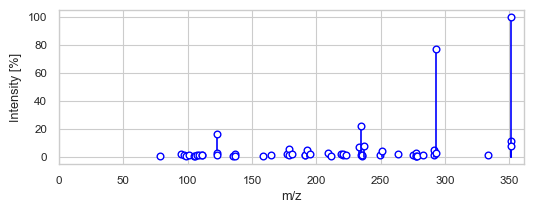

{'RT': 657.1141,
 'charge': 1,
 'file_name': b'MSV000086206_S_N3',
 'instrument accuracy est.': 0.00024381989,
 'lsh': b'16a6862c439a954fe27aa931034182690f31f751f5afa13f721befc4b9ab0e20',
 'precursor_mz': 351.17822}

In [9]:
msdata.at(0)